<ol>
<li>Preprocessing
    <ol>
        <li>Convert masks to bounding boxes</li>
    </ol>
</li>
<li>Select 1-2 models for transfer learning</li>
<li>Train and compare
    <ol>
        <li>integrating those models at different points (how many layers to cut out) </li>
        <li>with different image preparations</li>
        <li>hyperparameters</li>
    </ol>
</li>
<li></li>
<li></li>
<li></li>
</ol>

In [3]:
# Global imports
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# loading requirements for YOLOv5 into a separate environment from https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt 

c:\Users\Dgolberg\anaconda3\envs\yolo\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<h3>Data Preparation</h3>

<p>
The original contest was specifically aimed at object segmentation.  To those ends the training labels were provided in 2D run length encoded format where effectively the object is traced in pixels to a 2D array.  

While segmentation is a more difficult computational task than generating object classes with bounding boxes, we are here comparing methods for performing the latter.  One of the first tasks then is to convert the given segmentation masks into boxes.  

Additionally the training data is mostly comprised of images with no boats, or other classified objects.  To accelerate training those empty images need to be dereferenced, thereby removed from the training set.  

I borrowed the code in the rle_to_bbox.py file in this repository to generate a dictionary which accomplishes both mask to bounding box label transformation, as well as dereferencing.  Attributions are provided in rle_to_bbox.py.  

The generated dictionary, in bbox_dictionary.csv, now has entries in the format of <image filename>, [(min_row, min_col, max_row, max_col), ...].  

I am using the data generator from the <a href="https://github.com/pierluigiferrari/ssd_keras/tree/master/data_generator">ssd_keras repository</a> which requires each object to be given with the image file name, class ID, and box dimensions.  The code for this conversion follows
</p>

In [ ]:
# TODO: this can probably be deleted

#import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#from skimage.data import imread
#import matplotlib.pyplot as plt

#'C:\Users\Dgolberg\workspace\2022-courses\Computer_Vision\final_project\data_set/original'

# labels_filename (str): The filepath to a CSV file that contains one ground truth bounding box per line
    # and each line contains the following six items: image file name, class ID, xmin, xmax, ymin, ymax.
    # The six items do not have to be in a specific order, but they must be the first six columns of
    # each line. The order of these items in the CSV file must be specified in `input_format`.
    # The class ID is an integer greater than zero. Class ID 0 is reserved for the background class.
    # `xmin` and `xmax` are the left-most and right-most absolute horizontal coordinates of the box,
    # `ymin` and `ymax` are the top-most and bottom-most absolute vertical coordinates of the box.
    # The image name is expected to be just the name of the image file without the directory path
    # at which the image is located.

import csv

def map_for_data_gen(): 
    with open('bbox_dictionary.csv') as file:
        content = file.readlines()
        rows = content[1:]

        new_header = ['img_file_name', 'class_ID', 'ymin', 'xmin', 'ymax', 'xmax']

        class_ID = 'boat'
        res = []
        for row in rows: 
            row = row.split(',[(')
            imgname = row[0]
            row = row[1][:-3].split('), (')
            res.extend([[imgname, class_ID] + (r.split(',')) for r in row])

        with open('labels.csv', 'w', newline="") as f:
            csvwriter = csv.writer(f) 
            csvwriter.writerow(new_header)
            csvwriter.writerows(res) 

        return res

map_for_data_gen()


In [6]:
from pascal_voc_writer import Writer

# NOTE: pascal voc uses one file per image
# TODO: convert to use new objects extracted from file

def map_to_xml(): 
    IMG_WIDTH = 768
    IMG_HEIGHT = 768
    CLASS_ID = 'boat'
    with open('bbox_dictionary.csv') as file:
        content = file.readlines()
        rows = content[1:]

        # new_header = ['img_file_name', 'class_ID', 'ymin', 'xmin', 'ymax', 'xmax']
        # res = []
        for row in rows: 
            row = row.split(',[(')
            imgname = row[0]
            objects_list = row[1][:-3].split('), (')
            # res.extend([[imgname, class_ID] + (r.split(',')) for r in row])
            # create pascal voc writer (image_path, width, height)
            writer = Writer('data_set/original/train_v2/' + imgname, IMG_WIDTH, IMG_HEIGHT)

            # add objects 
            dimensions_list = [r.split(',') for r in objects_list]
            for o in dimensions_list: 
                # ['ymin', 'xmin', 'ymax', 'xmax'] to [class, xmin, ymin, xmax, ymax]
                writer.addObject(CLASS_ID, o[1], o[0], o[3], o[2])
                
            # write to file
            writer.save('data_set/labels/pascal_encoded/' + imgname[:-4] + '.xml')
map_to_xml()
                

In [1]:
import csv

# convert adhoc box format to objects we can use anywhere
def extract_from_bbox_dict(path, class_id):
    def convert_to_obj(b):
        return {
            'class_id': class_id, 
            'ymin': int(b[0]), 
            'xmin': int(b[1]), 
            'ymax': int(b[2]),
            'xmax': int(b[3])
        }
    with open(path) as file:
        content = file.readlines()
        rows = content[1:]
        bbox_dict = dict()

        for row in rows: 
            row = row.split(',[(')
            imgname = row[0]
            objects_list = row[1][:-3].split('), (')

            bbox_dict[imgname] = [convert_to_obj(b) for b in [bbox.split(', ') for bbox in objects_list]]

    return bbox_dict

# Yolo conversion from pascal
# Each row is class x_center y_center width height format.
# Box coordinates must be normalized by the dimensions of the image (i.e. have values between 0 and 1)
# Class numbers are zero-indexed (start from 0).
def write_yolo_files(bbox_obj_dict, img_width, img_height):
    def convert_to_yolo(obj): 
        return {
            'class_id': obj['class_id'], 
            'center_x': ((obj['xmin'] + obj['xmax']) / 2) / img_width,
            'center_y': ((obj['ymin'] + obj['ymax']) / 2) / img_height,
            'width': (obj['xmax'] - obj['xmin']) / img_width,
            'height': (obj['ymax'] - obj['ymin']) / img_height
        }

    for img in bbox_obj_dict.keys():
        # TODO: get rid of all these hard codings
        with open('data_set/labels/yolov5_encoded/' + img[:-4] + '.txt', 'w') as yolo_file:
            for o in [convert_to_yolo(obj) for obj in bbox_obj_dict[img]]: 
                yolo_file.write(f"{o['class_id']} {o['center_x']} {o['center_y']} {o['width']} {o['height']}\n")

# By creating a sorted list we can both avoid empty images for training, and restrict the dataset for development
def create_annotations_list(bbox_obj_dict):
    annotations = []
    for img in bbox_obj_dict.keys():
        annotations.append(img[:-4])

    annotations.sort()
    # NOTE: annotations list will have all images with objects
    with open('annotations.txt', 'w') as anf:
        for img in annotations:
            anf.write(f"{img}\n")
    return annotations

bbox_obj_dict = extract_from_bbox_dict('bbox_dictionary.csv', '0')
# write_yolo_files(bbox_obj_dict, 768, 768)

annotations = create_annotations_list(bbox_obj_dict)

annotations_subset = annotations[:5000]



<h3>Verify that our conversions were successful</h3>

<p>
    Running the cell below repeatedly will test a different image each time, drawing the bounding box from the YOLOv5 encodings we just created, and mapping the class back to a human legible label.

    Note: it is important the class you used during encoding doesn't conflict with the class labels used by any model incorporated for transfer leraning.  Per YoloV5 the classes should be sequentially numbered.    
       
    Per the original test data: boats which are occluded by the edge of the image aren't captured
</p>

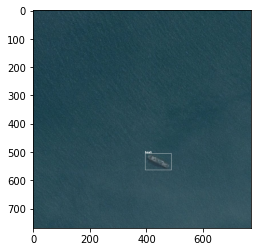

In [4]:
#  test box conversions
#  Adapted from https://blog.paperspace.com/train-yolov5-custom-data/ 

# TODO: move to constants or config
class_id_dict = {0:'boat', 'boat':0} 
class_id_to_name_mapping = class_id_dict

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    # print(f"annotations[:,[1,3]] {annotations[:,[1,3]]}, annotations[:,[2,4]] {annotations[:,[2,4]]}")
    
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]

    # print(f"transformed_annotations[:,1] {transformed_annotations[:,1]}, transformed_annotations[:,2] {transformed_annotations[:,2] }")
    # print(f"transformed_annotations[:,3] {transformed_annotations[:,3]}, transformed_annotations[:,4] {transformed_annotations[:,4] }")
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)

with open('data_set/labels/yolov5_encoded/' + annotation_file + '.txt', "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = 'data_set/original/train_v2/' + annotation_file + '.jpg'
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)



The conversion from an adhoc mask, to an adhoc bounding box, to Yolov5 appears to have been successful!  

In [ ]:
# NOTE:
# TODO:
# Image transformations should go here prior to actual training
# YoloV5 transforms during training



In [6]:
# Read images and annotations
# images = [os.path.join('data_set/original/train_v2/', x) for x in os.listdir('images')]
# annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]


# images.sort()
# annotations.sort()

images = [f"data_set/original/train_v2/{x}.jpg" for x in annotations_subset]
labels = [f"data_set/labels/yolov5_encoded/{x}.txt" for x in annotations_subset]

# Split the dataset into train-valid-test splits 
# train_images, val_images, train_annotations, val_annotations = train_test_split(annotations_subset, annotations_subset, test_size = 0.3, random_state = 1)
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size = 0.3, random_state = 1)
val_images, test_images, val_labels, test_labels = train_test_split(val_images, val_labels, test_size = 0.5, random_state = 1)

Transfer files into appropriate folders for yolov5

In [9]:

def copy_files(file_list, destination):
    for f in file_list:
        try:
            shutil.copy(f, destination)
        except: 
            print(f)
            assert False

copy_files(train_images, 'data_set/images/' + 'train')
copy_files(test_images, 'data_set/images/' + 'test')
copy_files(val_images, 'data_set/images/' + 'validation')
copy_files(train_labels, 'data_set/labels/' + 'train')
copy_files(test_labels, 'data_set/labels/' + 'test')
copy_files(val_labels, 'data_set/labels/' + 'validation')

<h3>SSD with vgg16 transfer learning</h3>

In [7]:
# from keras.preprocessing.image import ImageDataGenerator
# from keras.preprocessing import image
# from keras.applications import imagenet_utils
# from keras.applications import vgg16
# from keras.applications import mobilenet
# from keras.optimizers import adam_v2 as Adam, gradient_descent_v2 as SGD
# from keras.metrics import categorical_crossentropy
# from sklearn.metrics import confusion_matrix
# import itertools
# import matplotlib.pyplot as plt
# %matplotlib inline